## Predicting Pokémon from image with CNN
### Problem:
- **Objective**: Predict who is that Pokemon using images
- **How**: Building a Convolutional Neural Network for Multi-Class Classification.
- **Dataset**: 2,500+ clean labeled images, all official art, for Generations 1 through 8. (e.g., airplanes, cars, cats, dogs, etc.) (CIFAR-10 Dataset)
- **Target variable**: Pokemon name

### Steps:
**Load the Dataset**: Complete Pokemon Image Dataset from Kaggle ([Link Here](https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset))

**Preprocess the Data**:
  1) Define transform for preprocessing the data (normalizing pixel values between 0 and 1)
  2) Load the train CIFAR-10 dataset
  3) Load the test CIFAR-10 dataset
  4) Create DataLoaders for train and test sets

**Build the Neural Network**: Convolutional Neural Network with the following layers:

*Convolutional Layers*: Each convolutional layer uses a 3x3 kernel to extract features. The number of filters (32 and 64) increases as we go deeper into the network.

*Max Pooling Layers*: Max-pooling layers reduce the size of the feature maps (2x2 window), keeping the most important information.

*Fully Connected Layers*: After flattening the 3D output from the convolutional layers, the fully connected layers are used to classify the image into one of the 10 classes.

**Train the Model**: 
 1) Use the Cross Entropy loss function and Adam optimizer. 
 2) Train for 10 epochs.
 3) Calculate and print the train loss during training.

**Evaluate the Model**:  
 1) Calculate test loss after training.
 2) Plot training loss curve
 3) Calculate R-squared
 4) Plot Confusion Matrix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
dataset_dir = './data/pkmn'

dataset = ImageFolder(root=dataset_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

image, label = train_dataset[0]
#dir(image)
print(f'Image shape: {image.size}, Label: {label}')

Image shape: (360, 337), Label: 328


In [ ]:
dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((360, 360)),  # Resize images to a uniform size, seen in image size step before
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

# Example of accessing data
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")

Total Classes: 898
Batch of images shape: torch.Size([32, 3, 360, 360])
Batch of labels shape: torch.Size([32])


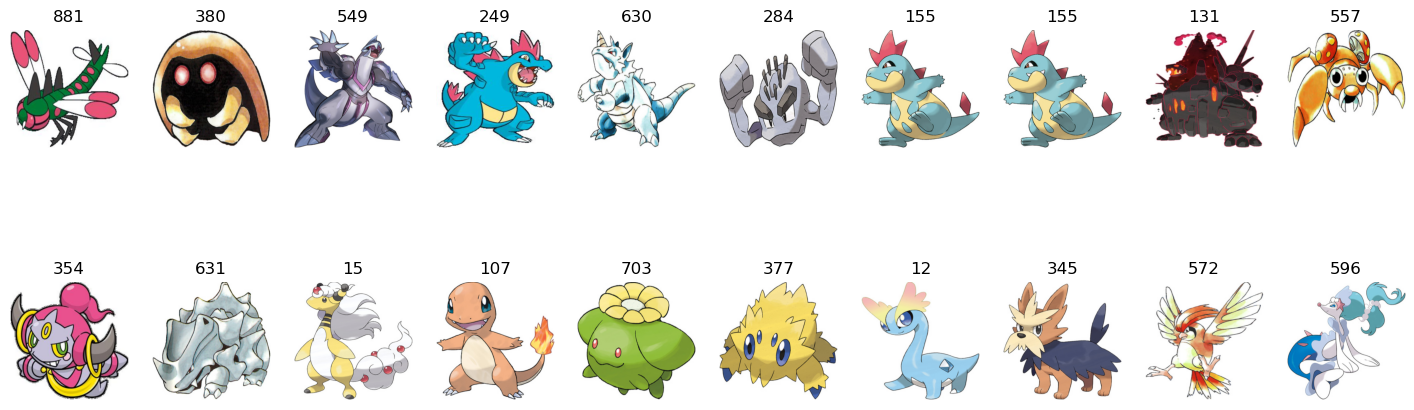

In [ ]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    # Denormalize the image for proper visualization
    img = img * 0.5 + 0.5  # Reverse the normalization (0.5 mean, 0.5 std)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    
    # Convert from Tensor to NumPy and transpose the channels (C, H, W) -> (H, W, C)
    plt.imshow(img.permute(1, 2, 0))  # For RGB images, no need to use cmap="gray"
    
plt.show()

In [ ]:
class PokeCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PokeCNN, self).__init__()
        # Define the convolutional layers

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)  # First conv layer (32 filters)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Define fully connected layers
        self.fc1 = nn.Linear(256, 1024)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(1024, output_size)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Global Average Pooling
        x = self.gap(x)  # Output size is now (batch_size, 256, 1, 1)
        x = x.view(-1, 256)  # Flatten

        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
class PokeCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PokeCNN, self).__init__()
        # Define the convolutional layers

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)  # First conv layer (32 filters)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Define fully connected layers
        self.fc1 = nn.Linear(256, 1024)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(1024, output_size)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Global Average Pooling
        x = self.gap(x)  # Output size is now (batch_size, 256, 1, 1)
        x = x.view(-1, 256)  # Flatten

        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
input_size = images.shape[1]
output_size = 898
model = PokeCNN(input_size, output_size)

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 10
train_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 1/10, Loss: 6.8130
Epoch 2/10, Loss: 6.7624
Epoch 3/10, Loss: 6.5627
Epoch 4/10, Loss: 6.2865
Epoch 5/10, Loss: 6.1022
Epoch 6/10, Loss: 5.9769
Epoch 7/10, Loss: 5.8920
Epoch 8/10, Loss: 5.8198
Epoch 9/10, Loss: 5.7526
Epoch 10/10, Loss: 5.7024


In [ ]:
correct = 0
total = 0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 0.20%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
dataset_dir = './data/pkmn'

dataset = ImageFolder(root=dataset_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

image, label = train_dataset[0]
#dir(image)
print(f'Image shape: {image.size}, Label: {label}')
dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a uniform size, seen in image size step before
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

# Example of accessing data
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
class PokeCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PokeCNN, self).__init__()
        # Define the convolutional layers

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)  # First conv layer (32 filters)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Batch normalization and dropout
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Define fully connected layers
        self.fc1 = nn.Linear(256, 1024)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(1024, output_size)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.pool(x)

        # Global Average Pooling
        x = self.gap(x)  # Output size is now (batch_size, 256, 1, 1)
        x = x.view(-1, 256)  # Flatten

        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
input_size = images.shape[1]
output_size = 898
model = PokeCNN(input_size, output_size)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
train_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

correct = 0
total = 0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Image shape: (360, 278), Label: 405
Total Classes: 898
Batch of images shape: torch.Size([32, 3, 256, 256])
Batch of labels shape: torch.Size([32])
Epoch 1/10, Loss: 6.8105
Epoch 2/10, Loss: 5.8643
Epoch 3/10, Loss: 5.1099
Epoch 4/10, Loss: 4.5242
Epoch 5/10, Loss: 4.0606
Epoch 6/10, Loss: 3.6446
Epoch 7/10, Loss: 3.3056
Epoch 8/10, Loss: 3.0255
Epoch 9/10, Loss: 2.7102
Epoch 10/10, Loss: 2.5052
Accuracy on the test set: 5.79%


### Increasing LR, adding data augmentation, input image size = 224

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

dataset_dir = './data/pkmn'

dataset = ImageFolder(root=dataset_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

image, label = train_dataset[0]
#dir(image)
print(f'Image shape: {image.size}, Label: {label}')
dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

# Example of accessing data
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
class PokeCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PokeCNN, self).__init__()
        # Define the convolutional layers

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)  # First conv layer (64 filters)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second conv layer (128 filters)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Third conv layer (256 filters)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Third conv layer (256 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Batch normalization and dropout
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Define fully connected layers
        self.fc1 = nn.Linear(512, 1024)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(1024, output_size)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.bn4(x)
        x = self.pool(x)

        # Global Average Pooling
        x = self.gap(x)  # Output size is now (batch_size, 256, 1, 1)
        x = x.view(-1, 512)  # Flatten

        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
input_size = images.shape[1]
output_size = 898
model = PokeCNN(input_size, output_size)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 50
train_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

correct = 0
total = 0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Image shape: (360, 276), Label: 862
Total Classes: 898
Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Epoch 1/50, Loss: 6.8204
Epoch 2/50, Loss: 6.4951
Epoch 3/50, Loss: 6.0442
Epoch 4/50, Loss: 5.5870
Epoch 5/50, Loss: 5.2509
Epoch 6/50, Loss: 4.9031
Epoch 7/50, Loss: 4.5678
Epoch 8/50, Loss: 4.2567
Epoch 9/50, Loss: 4.0055
Epoch 10/50, Loss: 3.7562
Epoch 11/50, Loss: 3.5058
Epoch 12/50, Loss: 3.3019
Epoch 13/50, Loss: 3.1032
Epoch 14/50, Loss: 2.9026
Epoch 15/50, Loss: 2.7499
Epoch 16/50, Loss: 2.6011
Epoch 17/50, Loss: 2.4504
Epoch 18/50, Loss: 2.3524
Epoch 19/50, Loss: 2.2185
Epoch 20/50, Loss: 2.1327
Epoch 21/50, Loss: 2.0142
Epoch 22/50, Loss: 1.9263
Epoch 23/50, Loss: 1.8536
Epoch 24/50, Loss: 1.7412
Epoch 25/50, Loss: 1.6505
Epoch 26/50, Loss: 1.6570
Epoch 27/50, Loss: 1.5319
Epoch 28/50, Loss: 1.5023
Epoch 29/50, Loss: 1.4256
Epoch 30/50, Loss: 1.3372
Epoch 31/50, Loss: 1.3079
Epoch 32/50, Loss: 1.2484
Epoch 33/50, Loss: 1.1796
Epo

In [ ]:
images.shape[1]

3

Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f572a1b0a00>, Label: 616
Epoch 1/50, Train Loss: 6.8191, Val Loss: 6.7842
Epoch 2/50, Train Loss: 6.5710, Val Loss: 6.7426
Epoch 3/50, Train Loss: 6.2153, Val Loss: 6.7332
Epoch 4/50, Train Loss: 5.7766, Val Loss: 6.8304
Epoch 5/50, Train Loss: 5.4275, Val Loss: 6.7929
Epoch 6/50, Train Loss: 5.1430, Val Loss: 6.8750
Epoch 7/50, Train Loss: 4.8417, Val Loss: 6.9143
Epoch 8/50, Train Loss: 4.6312, Val Loss: 7.0379
Epoch 9/50, Train Loss: 4.3522, Val Loss: 6.9073
Epoch 10/50, Train Loss: 4.1866, Val Loss: 7.0389
Epoch 11/50, Train Loss: 3.9843, Val Loss: 6.9583
Epoch 12/50, Train Loss: 3.8367, Val Loss: 6.9615
Epoch 13/50, Train Loss: 3.6522, Val Loss: 7.3211
Epoch 14/50, Train Loss: 3.5406, Val Loss: 7.0762
Epoch 15/50, Train Loss: 3.4212, Val Loss: 6.9988
Epoch 16/50, Train Loss: 3.2857, Val Loss: 7.2848
Epoch 17/50, Train Loss: 3.0999, Val Loss: 6.9607
Epoch 18/50, Train Loss: 2.9625, Val Loss: 7.1305
Epoch 1

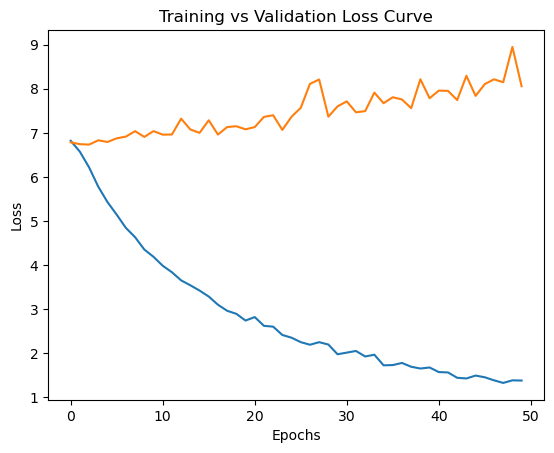

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

class PokeCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(PokeCNN, self).__init__()
        # Define the convolutional layers

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=128, kernel_size=3, padding=1)  # First conv layer (64 filters)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Second conv layer (128 filters)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Third conv layer (256 filters)
        #self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)  # Third conv layer (256 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Batch normalization and dropout
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        #self.bn4 = nn.BatchNorm2d(1024)
        self.dropout = nn.Dropout(0.5)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Define fully connected layers
        self.fc1 = nn.Linear(512, 1024)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(1024, output_size)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.pool(x)
        #x = self.conv4(x)
        #x = torch.relu(x)
        #x = self.bn4(x)
        #x = self.pool(x)

        # Global Average Pooling
        x = self.gap(x)  # Output size is now (batch_size, 256, 1, 1)
        x = x.view(-1, 512)  # Flatten

        # Apply fully connected layers
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
input_size = images.shape[1]
output_size = 898
model = PokeCNN(input_size, output_size)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 50
train_losses = []
val_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()

Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f5808560730>, Label: 407


/home/cmadaria/miniforge3/envs/test-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cmadaria/miniforge3/envs/test-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/cmadaria/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Epoch 1/50, Train Loss: 7.1878, Val Loss: 7.1898
Epoch 2/50, Train Loss: 6.4737, Val Loss: 7.1770
Epoch 3/50, Train Loss: 6.1660, Val Loss: 7.1402
Epoch 4/50, Train Loss: 5.9280, Val Loss: 7.0865
Epoch 5/50, Train Loss: 5.6591, Val Loss: 7.0015
Epoch 6/50, Train Loss: 5.4778, Val Loss: 6.9419
Epoch 7/50, Train Loss: 5.2135, Val Loss: 6.8946
Epoch 8/50, Train Loss: 5.0225, Val Loss: 6.8340
Epoch 9/50, Train Loss: 4.7933, Val Loss: 6.7390
Epoch 10/50, Train Loss: 4.6141, Val Loss: 6.6697
Epoch 11/50, Train Loss: 4.3798, Val Loss: 6.5753
Epoch 12/50, Train Loss: 4.2106, Val Loss: 6.5030
Epoch 13/50, Train Loss: 4.0038, Val Loss: 6.4251
Epoch 14/50, Train Loss: 3.8040, Val Loss: 6.3608
Epoch 15/50, Train Loss: 3.6528, Val Loss: 6.2901
Epoch 16/50, Train Loss: 3.4169, Val Loss: 6.2256
Epoch 17/50, Train Loss: 3.2745, Val Loss: 6.1945
Epoch 18/50, Train Loss: 3.1128, Val Loss: 6.1143
Epoch 19/50, Train Loss: 2.9801, Val Loss: 6.0690
Epoch 20/50, Train Loss: 2.8024, Val Loss: 5.9938
Epoch 21/

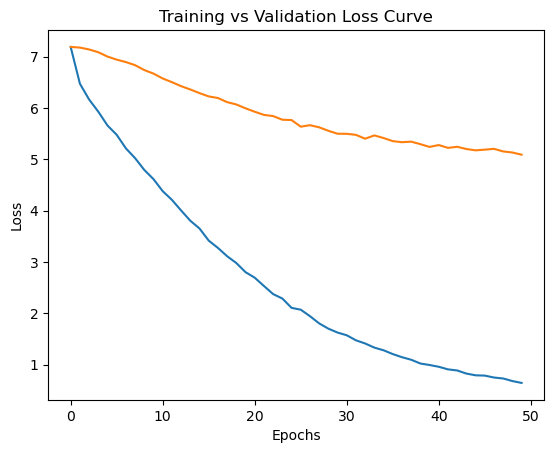

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.models as models

dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer to match the number of classes in your dataset (898)
num_ftrs = model.fc.in_features  # Get the input features of the last fully connected layer
model.fc = nn.Linear(num_ftrs, 898)  # Replace the final layer for 898 classes

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # Only optimize the final layer

epochs = 50
train_losses = []
val_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()

Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f572a0aa490>, Label: 356
Epoch 1/50, Train Loss: 7.0589, Val Loss: 7.0503
Epoch 2/50, Train Loss: 5.8431, Val Loss: 6.7344
Epoch 3/50, Train Loss: 4.9354, Val Loss: 6.3661
Epoch 4/50, Train Loss: 4.0122, Val Loss: 6.0183
Epoch 5/50, Train Loss: 3.2167, Val Loss: 5.6158
Epoch 6/50, Train Loss: 2.4715, Val Loss: 5.2450
Epoch 7/50, Train Loss: 1.8717, Val Loss: 4.9145
Epoch 8/50, Train Loss: 1.3267, Val Loss: 4.5962
Epoch 9/50, Train Loss: 0.9481, Val Loss: 4.3177
Epoch 10/50, Train Loss: 0.6675, Val Loss: 4.0850
Epoch 11/50, Train Loss: 0.4975, Val Loss: 3.9291
Epoch 12/50, Train Loss: 0.3608, Val Loss: 3.7678
Epoch 13/50, Train Loss: 0.3120, Val Loss: 3.6976
Epoch 14/50, Train Loss: 0.2405, Val Loss: 3.6328
Epoch 15/50, Train Loss: 0.2313, Val Loss: 3.5906
Epoch 16/50, Train Loss: 0.2121, Val Loss: 3.5787
Epoch 17/50, Train Loss: 0.2016, Val Loss: 3.5317
Epoch 18/50, Train Loss: 0.1980, Val Loss: 3.5337
Epoch 1

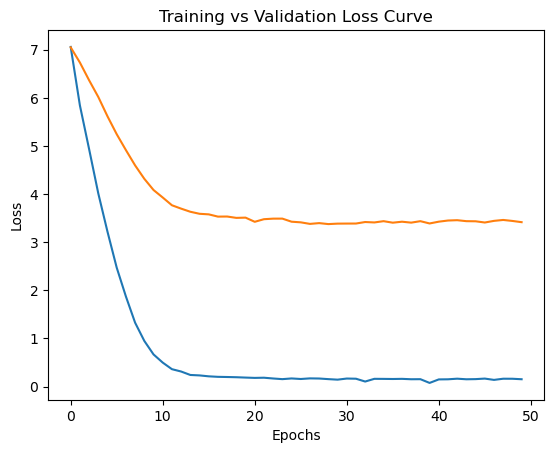

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.models as models

dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer to match the number of classes in your dataset (898)
num_ftrs = model.fc.in_features  # Get the input features of the last fully connected layer
model.fc = nn.Linear(num_ftrs, 898)  # Replace the final layer for 898 classes

# Freeze all layers except the final fully connected layer
#for param in model.parameters():
#    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last fully connected layer
#for param in model.fc.parameters():
#    param.requires_grad = True

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Only optimize the final layer

epochs = 50
train_losses = []
val_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()

In [ ]:
import os

# Path to your dataset directory
dataset_dir = './data/pkmn'

# Dictionary to store counts for each class
class_counts = {}

# Iterate through each subdirectory (each representing a class)
for class_dir in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_dir)

    # Ensure the path is a directory (i.e., ignore files, if any)
    if os.path.isdir(class_path):
        # Count the number of image files in the directory
        num_images = len(os.listdir(class_path))
        class_counts[class_dir] = num_images

# Print the count of images for each class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' has {count} images.")

Class 'Abomasnow' has 4 images.
Class 'Abra' has 4 images.
Class 'Absol' has 4 images.
Class 'Accelgor' has 2 images.
Class 'Aegislash' has 4 images.
Class 'Aerodactyl' has 6 images.
Class 'Aggron' has 4 images.
Class 'Aipom' has 3 images.
Class 'Alakazam' has 6 images.
Class 'Alcremie' has 2 images.
Class 'Alomomola' has 2 images.
Class 'Altaria' has 4 images.
Class 'Amaura' has 2 images.
Class 'Ambipom' has 2 images.
Class 'Amoonguss' has 2 images.
Class 'Ampharos' has 5 images.
Class 'Anorith' has 2 images.
Class 'Appletun' has 2 images.
Class 'Applin' has 1 images.
Class 'Araquanid' has 2 images.
Class 'Arbok' has 4 images.
Class 'Arcanine' has 4 images.
Class 'Arceus' has 5 images.
Class 'Archen' has 2 images.
Class 'Archeops' has 2 images.
Class 'Arctovish' has 1 images.
Class 'Arctozolt' has 1 images.
Class 'Ariados' has 3 images.
Class 'Armaldo' has 2 images.
Class 'Aromatisse' has 2 images.
Class 'Aron' has 2 images.
Class 'Arrokuda' has 1 images.
Class 'Articuno' has 6 images

### Balancing classes underrepresented:
This way, the loss function will give more importance to underrepresented classes, helping the model to learn better for those classes.

Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f550914f340>, Label: 790


/home/cmadaria/miniforge3/envs/test-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cmadaria/miniforge3/envs/test-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 7.1121, Val Loss: 7.4339
Epoch 2/50, Train Loss: 5.8801, Val Loss: 6.8386
Epoch 3/50, Train Loss: 4.9910, Val Loss: 6.5906
Epoch 4/50, Train Loss: 4.0933, Val Loss: 6.2742
Epoch 5/50, Train Loss: 3.2798, Val Loss: 5.8723
Epoch 6/50, Train Loss: 2.4997, Val Loss: 5.5667
Epoch 7/50, Train Loss: 1.8991, Val Loss: 5.1682
Epoch 8/50, Train Loss: 1.3811, Val Loss: 4.7820
Epoch 9/50, Train Loss: 1.0059, Val Loss: 4.4804
Epoch 10/50, Train Loss: 0.7382, Val Loss: 4.2351
Epoch 11/50, Train Loss: 0.5511, Val Loss: 4.0364
Epoch 12/50, Train Loss: 0.4151, Val Loss: 3.9309
Epoch 13/50, Train Loss: 0.3331, Val Loss: 3.8553
Epoch 14/50, Train Loss: 0.2706, Val Loss: 3.7420
Epoch 15/50, Train Loss: 0.2604, Val Loss: 3.7429
Epoch 16/50, Train Loss: 0.2234, Val Loss: 3.6902
Epoch 17/50, Train Loss: 0.2150, Val Loss: 3.6538
Epoch 18/50, Train Loss: 0.1962, Val Loss: 3.6060
Epoch 19/50, Train Loss: 0.1916, Val Loss: 3.5799
Epoch 20/50, Train Loss: 0.1818, Val Loss: 3.5937
Epoch 21/

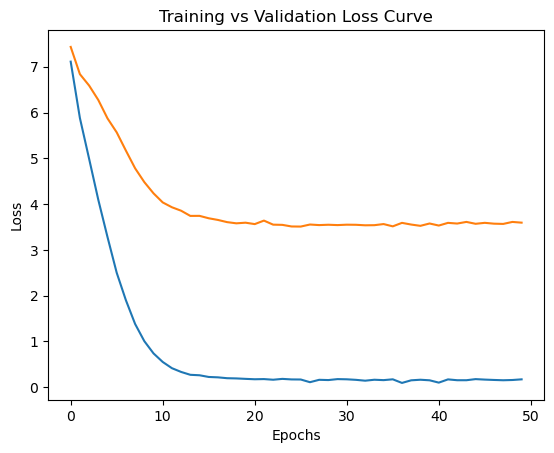

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.models as models

dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer to match the number of classes in your dataset (898)
num_ftrs = model.fc.in_features  # Get the input features of the last fully connected layer
model.fc = nn.Linear(num_ftrs, 898)  # Replace the final layer for 898 classes

# Freeze all layers except the final fully connected layer
#for param in model.parameters():
#    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last fully connected layer
#for param in model.fc.parameters():
#    param.requires_grad = True

device = torch.device('cuda:0')

# Convert class counts to weights
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
# Create a tensor for class weights
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)
class_weights_tensor = class_weights_tensor.to(device)

loss = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use these weights in your loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Only optimize the final layer

epochs = 50
train_losses = []
val_losses = []

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import WeightedRandomSampler
from collections import Counter


dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Generate a list of class labels (targets)
targets = [label for _, label in dataset.samples]

# Count the frequency of each class in the dataset
class_counts = Counter(targets)

# Calculate weights for each class (inverse of the frequency)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Calculate weights for each sample based on class distribution
sample_weights = [class_weights[label] for label in targets]

# Create a WeightedRandomSampler with the sample weights
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Update the DataLoader to use the sampler
#train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer to match the number of classes in your dataset (898)
num_ftrs = model.fc.in_features  # Get the input features of the last fully connected layer
model.fc = nn.Linear(num_ftrs, 898)  # Replace the final layer for 898 classes

# Freeze all layers except the final fully connected layer
#for param in model.parameters():
#    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last fully connected layer
#for param in model.fc.parameters():
#    param.requires_grad = True

device = torch.device('cuda:0')

# Convert class counts to weights
#class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
# Create a tensor for class weights
#class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)
#class_weights_tensor = class_weights_tensor.to(device)

loss = nn.CrossEntropyLoss()#weight=class_weights_tensor) # Use these weights in your loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Only optimize the final layer

epochs = 50
train_losses = []
val_losses = []

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()

Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f5509878550>, Label: 895


IndexError: list index out of range

In [ ]:
# Check dataset lengths
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

# Check the number of batches in train and validation loaders
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")

Train dataset length: 1601
Validation dataset length: 401
Test dataset length: 501
Number of batches in train_loader: 79
Number of batches in val_loader: 13


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.models as models

dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer to match the number of classes in your dataset (898)
num_ftrs = model.fc.in_features  # Get the input features of the last fully connected layer
model.fc = nn.Linear(num_ftrs, 898)  # Replace the final layer for 898 classes

# Freeze all layers except the final fully connected layer
#for param in model.parameters():
#    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last fully connected layer
#for param in model.fc.parameters():
#    param.requires_grad = True

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Only optimize the final layer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

epochs = 40
train_losses = []
val_losses = []

device = torch.device('cuda:0')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()

Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f580856f2a0>, Label: 226
Epoch 1/40, Train Loss: 7.0194, Val Loss: 6.8393
Epoch 2/40, Train Loss: 5.7654, Val Loss: 6.5299
Epoch 3/40, Train Loss: 4.8094, Val Loss: 6.1665
Epoch 4/40, Train Loss: 3.9771, Val Loss: 5.7965
Epoch 5/40, Train Loss: 3.1613, Val Loss: 5.4102
Epoch 6/40, Train Loss: 2.4220, Val Loss: 5.0658


Total Classes: 898
Image shape: <built-in method size of Tensor object at 0x7f550c61a710>, Label: 374
Epoch 1/40, Train Loss: 7.0192, Val Loss: 7.0765
Epoch 2/40, Train Loss: 5.8151, Val Loss: 6.7142
Epoch 3/40, Train Loss: 4.8964, Val Loss: 6.3298
Epoch 4/40, Train Loss: 4.0368, Val Loss: 6.0129
Epoch 5/40, Train Loss: 3.2499, Val Loss: 5.5858
Epoch 6/40, Train Loss: 2.5512, Val Loss: 5.2549
Epoch 7/40, Train Loss: 1.9345, Val Loss: 4.8777
Epoch 8/40, Train Loss: 1.4414, Val Loss: 4.5411
Epoch 9/40, Train Loss: 1.0063, Val Loss: 4.2032
Epoch 10/40, Train Loss: 0.7347, Val Loss: 4.0172
Epoch 11/40, Train Loss: 0.5243, Val Loss: 3.7549
Epoch 12/40, Train Loss: 0.3983, Val Loss: 3.6014
Epoch 13/40, Train Loss: 0.2991, Val Loss: 3.5235
Epoch 14/40, Train Loss: 0.2679, Val Loss: 3.4204
Epoch 15/40, Train Loss: 0.2295, Val Loss: 3.3948
Epoch 16/40, Train Loss: 0.2070, Val Loss: 3.3853
Epoch 17/40, Train Loss: 0.1893, Val Loss: 3.3366
Epoch 18/40, Train Loss: 0.1895, Val Loss: 3.3023
Epoch 1

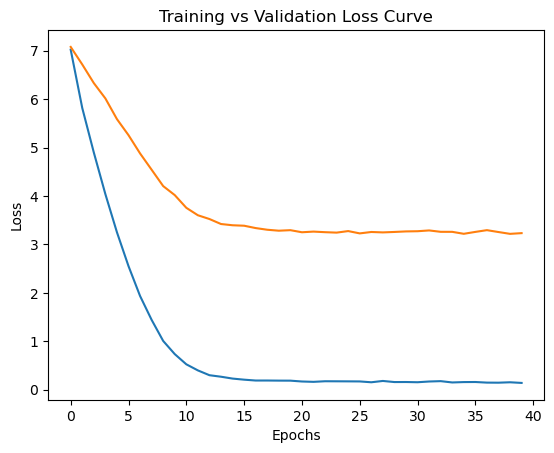

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.models as models

dataset_dir = './data/pkmn'

# Define image transformations (you can add more transformations if needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size, seen in image size step before
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

dataset = ImageFolder(root=dataset_dir, transform=transform)

# Split the dataset into train and test sets (optional)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the class names (subfolder names)
print(f"Total Classes: {len(dataset.classes)}")

image, label = train_dataset[0]
print(f'Image shape: {image.size}, Label: {label}')

# Load a pretrained ResNet model
model = models.resnet50(pretrained=True)

# Replace the last fully connected layer to match the number of classes in your dataset (898)
num_ftrs = model.fc.in_features  # Get the input features of the last fully connected layer
model.fc = nn.Linear(num_ftrs, 898)  # Replace the final layer for 898 classes

# Freeze all layers except the final fully connected layer
#for param in model.parameters():
#    param.requires_grad = False  # Freeze all parameters

# Unfreeze the last fully connected layer
#for param in model.fc.parameters():
#    param.requires_grad = True

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Only optimize the final layer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

epochs = 40
train_losses = []
val_losses = []

device = torch.device('cuda:1')

model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop (no weight updates, just evaluating)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss_fn = loss(pred, labels)

            val_loss += loss_fn.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

correct = 0
total = 0
test_loss = 0.0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss += loss_fn.item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Plot the training & validation loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Curve')
plt.show()